# Análisis Preliminar de Simulaciones

Después de ejecutar las 10 simulaciones sugeridas, hemos formulado las siguientes hipótesis:

1. **No hay correlación lineal entre los factores ambientales.**
2. **Existe una correlación positiva entre las lecturas térmicas (*thermal readings*) y el éxito de la misión (*mission success*).**
3. **Se observa una correlación positiva entre la densidad poblacional (*population density*) y el éxito de la misión.**
4. **Se requiere más munición (*ammo*) y trajes de radiación (*radiation suits*) en comparación con explosivos (*explosives*).**
5. **El tamaño de las ciudades parece seguir una distribución uniforme.**

Para analizar los datos JSON, utilizaremos Python con las bibliotecas pandas, matplotlib, seaborn y numpy. Vamos a cargar los archivos JSON y realizar análisis específicos para cada una de tus hipótesis.

# Recuerda configurar donde tengas los archivos

In [23]:
%cd /Users/jeronimo/Desktop/Jero/VS_Code/IA/graph_zombie_repo
!pwd

/Users/jeronimo/Library/Python/3.11/lib/python/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/Users/jeronimo/Desktop/Jero/VS_Code/IA/graph_zombie_repo
/Users/jeronimo/Desktop/Jero/VS_Code/IA/graph_zombie_repo


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Cargar los archivos JSON
with open('./data/policies/EvacuationPolicy/experiments/20250303_0029/core_metrics.json', 'r') as f:
    core_metrics = json.load(f)
    
with open('./data/policies/EvacuationPolicy/experiments/20250303_0029/environmental_metrics.json', 'r') as f:
    env_metrics = json.load(f)
    
with open('./data/policies/EvacuationPolicy/experiments/20250303_0029/resource_metrics.json', 'r') as f:
    resource_metrics = json.load(f)


In [29]:
with open('/Users/jeronimo/Desktop/Jero/VS_Code/IA/graph_zombie_repo/data/policies/EvacuationPolicy/experiments/20250303_0029/raw_data.json', 'r') as f:
    raw_data = json.load(f)

# Hipótesis 1: No hay correlación lineal entre los factores ambientales
Para verificar esto, podemos crear una matriz de correlación entre todos los indicadores ambientales:

In [7]:
print(env_metrics['by_city_size']["33"]["nodes"])

{'seismic_activity': 0.44417132632598194, 'radiation_readings': 0.38764440943929407, 'population_density': 0.25418663764620064, 'emergency_calls': 0.7195117001435195, 'thermal_readings': 0.41644455363673594, 'signal_strength': 0.589934197478866, 'structural_integrity': 0.5524937112783906}


(31, 13)


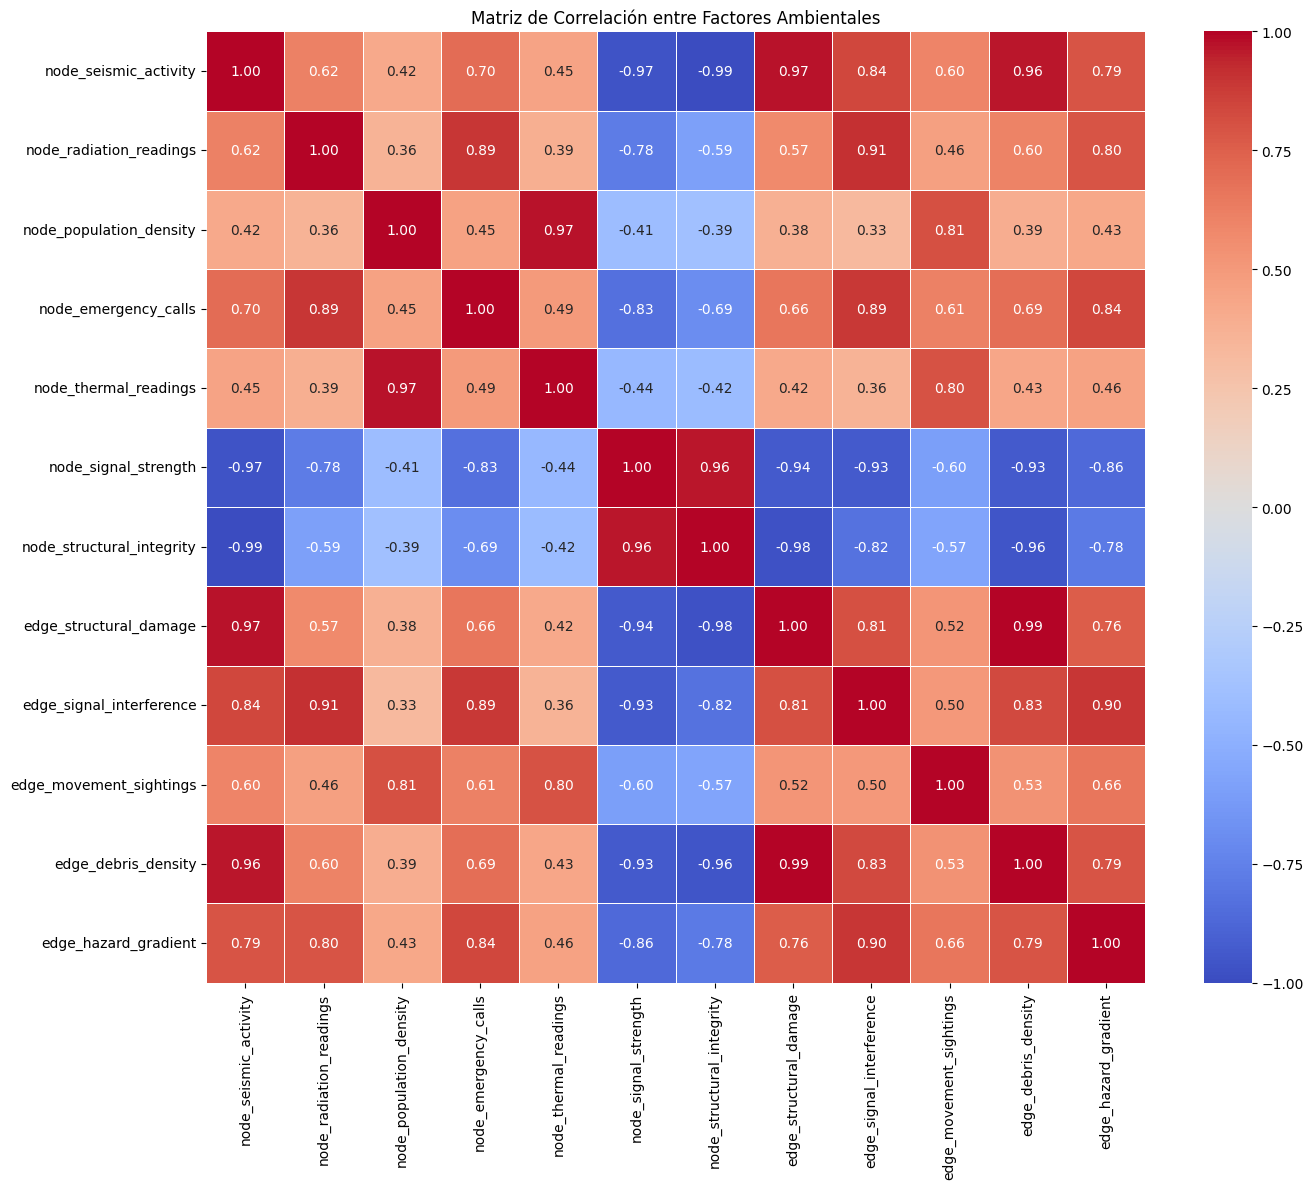

In [8]:
# Extraer los datos de los nodos y aristas
node_indicators = env_metrics['overall']['nodes']
edge_indicators = env_metrics['overall']['edges']

# Combinar ambos tipos de indicadores
all_indicators = {}
for k, v in node_indicators.items():
    all_indicators[f"node_{k}"] = v
for k, v in edge_indicators.items():
    all_indicators[f"edge_{k}"] = v

# Crear un DataFrame para facilitar el análisis
indicators_df = pd.DataFrame([all_indicators])
# Expandir el DataFrame para tener datos por ciudad
city_indicators = []
for size, metrics in env_metrics['by_city_size'].items():
    city_data = {'city_size': int(size)}
    for k, v in metrics['nodes'].items():
        city_data[f"node_{k}"] = v
    for k, v in metrics['edges'].items():
        city_data[f"edge_{k}"] = v
    city_indicators.append(city_data)

city_indicators_df = pd.DataFrame(city_indicators)
print(city_indicators_df.shape)
# Calcular y visualizar la matriz de correlación
plt.figure(figsize=(14, 12))
corr = city_indicators_df.drop('city_size', axis=1).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
            fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación entre Factores Ambientales')
plt.tight_layout()
plt.show()

# Hipótesis 2: Correlación positiva entre thermal readings, population density y mission success

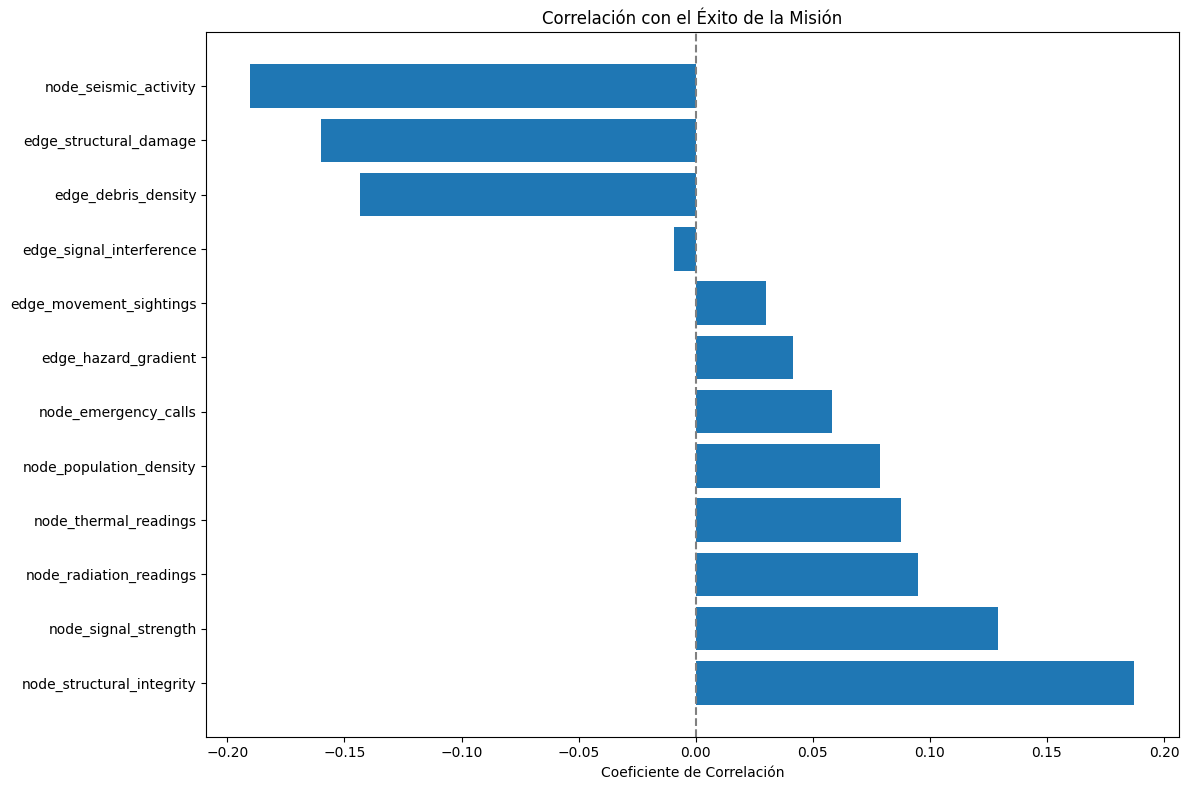

Correlaciones clave con éxito de la misión:
node_thermal_readings: 0.0875
node_population_density: 0.0787


In [9]:
# Extraer las correlaciones con el éxito de la misión
success_correlations = {
    **{f"node_{k}": v for k, v in env_metrics['correlations']['nodes'].items()},
    **{f"edge_{k}": v for k, v in env_metrics['correlations']['edges'].items()}
}

# Ordenar por valor de correlación
sorted_correlations = sorted(success_correlations.items(), key=lambda x: x[1], reverse=True)

# Visualizar las correlaciones
plt.figure(figsize=(12, 8))
indicators, values = zip(*sorted_correlations)
plt.barh(indicators, values)
plt.axvline(x=0, color='gray', linestyle='--')
plt.title('Correlación con el Éxito de la Misión')
plt.xlabel('Coeficiente de Correlación')
plt.tight_layout()
plt.show()

# Enfoque específico en thermal_readings y population_density
key_indicators = ['node_thermal_readings', 'node_population_density']
print("Correlaciones clave con éxito de la misión:")
for indicator in key_indicators:
    key = indicator.split('_', 1)[1]  # Eliminar el prefijo "node_"
    corr = env_metrics['correlations']['nodes'][key]
    print(f"{indicator}: {corr:.4f}")

Preguntarle a chat que son realmente los valores que hay dentro de environmental_metrics

# Hipótesis 3: Se necesitan más ammo y radiation_suits que explosives

In [10]:
print(resource_metrics['overall'].keys())

dict_keys(['explosives', 'ammo', 'radiation_suits'])


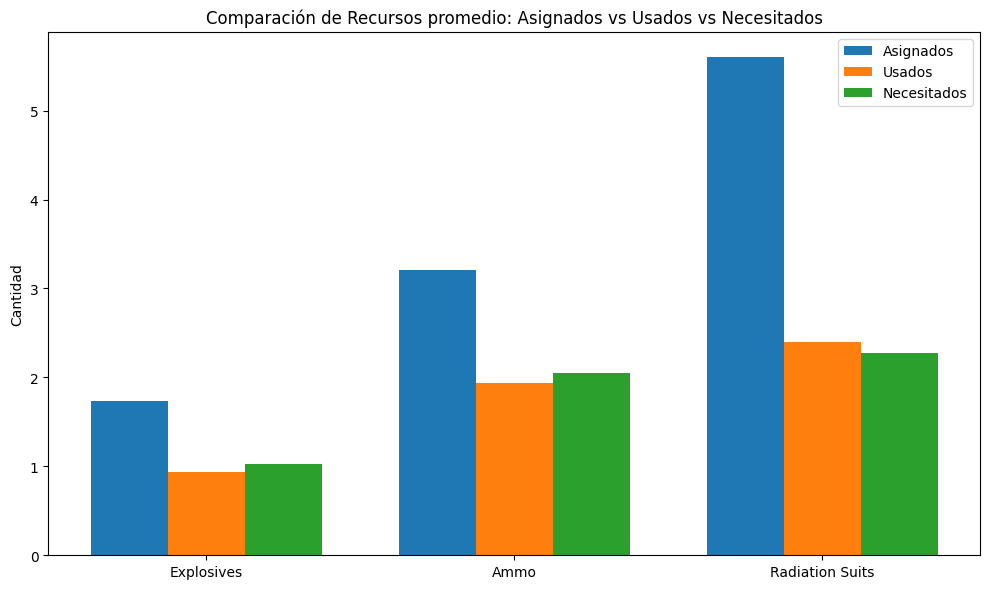

Estadísticas de uso de recursos:
              tipo  asignados  usados  necesitados  eficiencia
0       explosives      1.740   0.935        1.030    0.645000
1             ammo      3.210   1.940        2.045    0.879167
2  radiation_suits      5.605   2.400        2.270    0.794333

Recurso más usado: radiation_suits
Recurso más necesitado: radiation_suits


In [11]:
# Analizar el uso de recursos
resource_types = list(resource_metrics['overall'].keys())
allocated = [resource_metrics['overall'][rt]['avg_allocated'] for rt in resource_types]
used = [resource_metrics['overall'][rt]['avg_used'] for rt in resource_types]
needed = [resource_metrics['overall'][rt]['avg_needed'] for rt in resource_types]

# Crear un gráfico comparativo
plt.figure(figsize=(10, 6))
x = range(len(resource_types))
width = 0.25

plt.bar([i - width for i in x], allocated, width, label='Asignados')
plt.bar(x, used, width, label='Usados')
plt.bar([i + width for i in x], needed, width, label='Necesitados')

plt.xticks(x, [rt.replace('_', ' ').title() for rt in resource_types])
plt.ylabel('Cantidad')
plt.title('Comparación de Recursos promedio: Asignados vs Usados vs Necesitados')
plt.legend()
plt.tight_layout()
plt.show()

# Análisis estadístico
resource_df = pd.DataFrame({
    'tipo': resource_types,
    'asignados': allocated,
    'usados': used,
    'necesitados': needed,
    'eficiencia': [resource_metrics['overall'][rt]['efficiency'] for rt in resource_types]
})

print("Estadísticas de uso de recursos:")
print(resource_df)
print("\nRecurso más usado:", resource_metrics['analysis']['most_used_resource'])
print("Recurso más necesitado:", resource_metrics['analysis']['most_needed_resource'])

# Hipótesis 4: Distribución uniforme de tamaños de ciudades

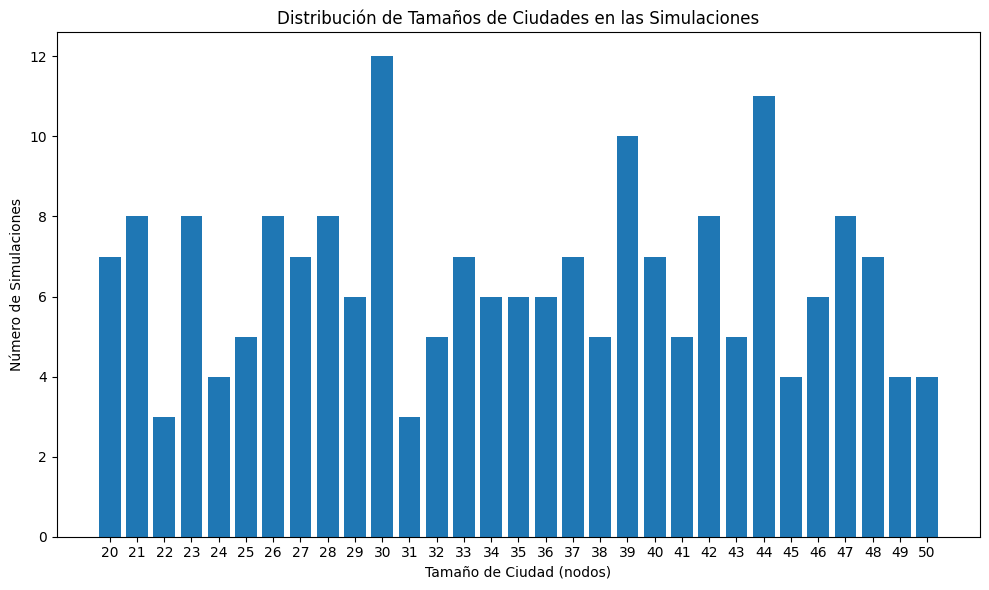

Test Chi-cuadrado para distribución uniforme: chi2=21.6500, p=0.8665
La distribución es estadísticamente uniforme (α=0.05)


In [12]:
# Extraer los tamaños de ciudades
city_sizes = list(core_metrics['by_city_size'].keys())
city_counts = {}
for size in city_sizes:
    city_counts[int(size)] = core_metrics['by_city_size'][size]['n_runs']

# Visualizar la distribución
plt.figure(figsize=(10, 6))
plt.bar(city_counts.keys(), city_counts.values())
plt.xlabel('Tamaño de Ciudad (nodos)')
plt.ylabel('Número de Simulaciones')
plt.title('Distribución de Tamaños de Ciudades en las Simulaciones')
plt.xticks(list(city_counts.keys()))
plt.tight_layout()
plt.show()

# Test chi-cuadrado para uniformidad
from scipy.stats import chisquare
expected = [sum(city_counts.values()) / len(city_counts)] * len(city_counts)
chi2, p = chisquare(list(city_counts.values()), expected)
print(f"Test Chi-cuadrado para distribución uniforme: chi2={chi2:.4f}, p={p:.4f}")
print(f"La distribución {'es' if p > 0.05 else 'no es'} estadísticamente uniforme (α=0.05)")

# Análisis adicional: Éxito por tamaño de ciudad

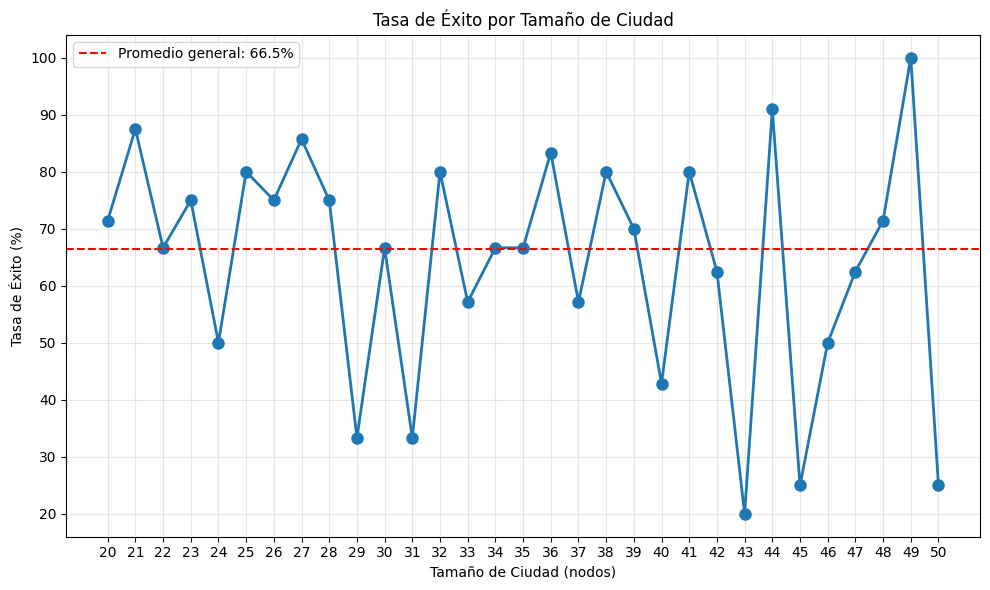

In [13]:
# Analizar tasa de éxito por tamaño de ciudad
sizes = []
success_rates = []

for size, metrics in core_metrics['by_city_size'].items():
    sizes.append(int(size))
    success_rates.append(metrics['success_rate'] * 100)

# Ordenar por tamaño
sorted_data = sorted(zip(sizes, success_rates))
sizes, success_rates = zip(*sorted_data)

plt.figure(figsize=(10, 6))
plt.plot(sizes, success_rates, 'o-', linewidth=2, markersize=8)
plt.axhline(y=core_metrics['overall_performance']['success_rate'] * 100, 
           color='r', linestyle='--', 
           label=f'Promedio general: {core_metrics["overall_performance"]["success_rate"]*100:.1f}%')
plt.xlabel('Tamaño de Ciudad (nodos)')
plt.ylabel('Tasa de Éxito (%)')
plt.title('Tasa de Éxito por Tamaño de Ciudad')
plt.xticks(sizes)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

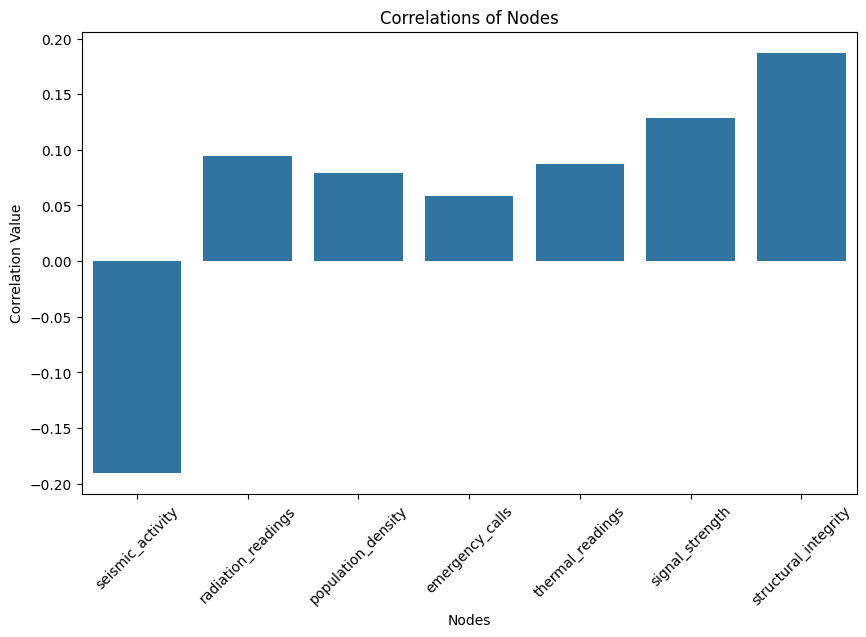

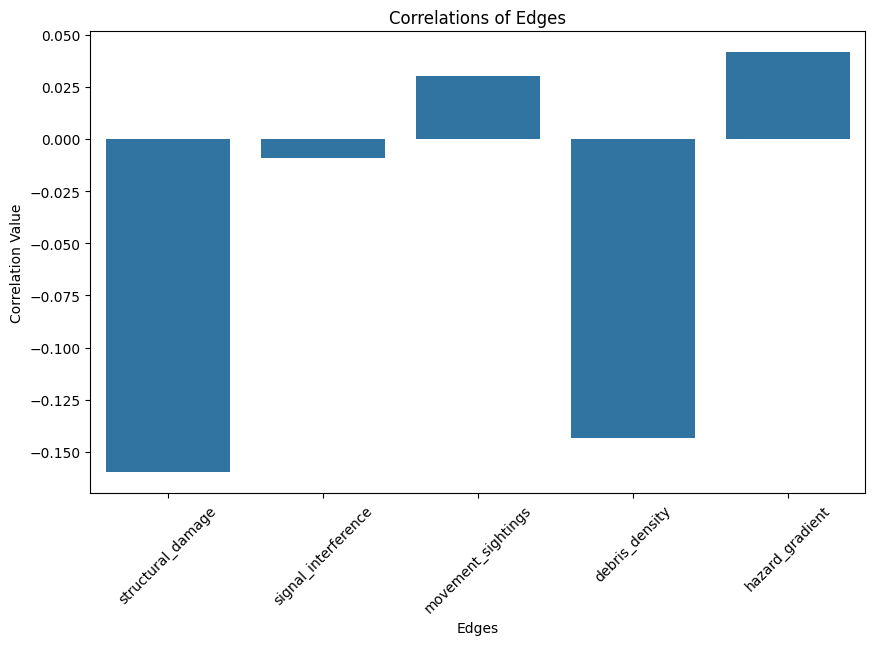

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import json

data= env_metrics

# Extraer los datos relevantes
overall_nodes = data['overall']['nodes']
overall_edges = data['overall']['edges']
city_sizes = data['by_city_size']
correlations_nodes = data['correlations']['nodes']
correlations_edges = data['correlations']['edges']



# Graficar las correlaciones de los nodos
plt.figure(figsize=(10, 6))
sns.barplot(x=list(correlations_nodes.keys()), y=list(correlations_nodes.values()))
plt.title('Correlations of Nodes')
plt.ylabel('Correlation Value')
plt.xlabel('Nodes')
plt.xticks(rotation=45)
plt.show()

# Graficar las correlaciones de las aristas
plt.figure(figsize=(10, 6))
sns.barplot(x=list(correlations_edges.keys()), y=list(correlations_edges.values()))
plt.title('Correlations of Edges')
plt.ylabel('Correlation Value')
plt.xlabel('Edges')
plt.xticks(rotation=45)
plt.show()

